# Radio Modulation Classification with FINN - Notebook #2 of 5

### Overview 
In this Notebook we again load the dataset and create our dataloader. Then we:
1. Define our model using Brevitas
2. Train, and test our new Brevitas model!

Portions of this notebook that have been covered in the previous notebook will have much less description (such as the dataloader). The more information please see the Tutorial1_Dataset_and_Vanilla_model.ipynb file!

### FINN Pipeline Map
Throughout these notebooks, you will begin to understand the FINN pipeline! In order the pipeline is:
1. Dataset and Vanilla model
2. **Brevitas Model** (you are here)
3. Transforming the Brevitas Model to tidy.onnx
4. Transforming tidy.onnx to bitstream
5. Loading the bitstream on the FPGA!

We are in **2. Brevitas Model.** This notebook will show you how to define a VGG-10 model using the Brevitas Framework, which allows us to quantize the model (i.e make a smaller model). Having a quantized model is required for the next steps of the pipeline!


### Packages, and Data 
First we import the required packages and create the dataloader for the dataset. The details of this are explained in Notebook 1.

In [1]:
# Import required pacakages 
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import time

In [2]:
# Using cuda 
assert torch.cuda.is_available(), 'Cuda not available'
gpu = 'cuda'

In [3]:
# Check if dataset is present
import os.path
dataset_path = "datasets/RADIOML_2021_07_INT8.hdf5"
os.path.isfile(dataset_path)

True

In [4]:
# Prepare data loader
from torch.utils.data import Dataset, DataLoader
import h5py

class radioml_21_dataset(Dataset):
    def __init__(self, dataset_path):
        super(radioml_21_dataset, self).__init__()
        h5_file = h5py.File(dataset_path,'r')
        self.data = h5_file['X']
        self.mod = np.argmax(h5_file['Y'], axis=1) # comes in one-hot encoding
        self.snr = h5_file['Z'][:,0]
        self.len = self.data.shape[0]

        self.mod_classes = [
                "OOK",
                "4ASK",
                "8ASK",
                "BPSK",
                "QPSK",
                "8PSK",
                "16PSK",
                "32PSK",
                "16APSK",
                "32APSK",
                "64APSK",
                "128APSK",
                "16QAM",
                "32QAM",
                "64QAM",
                "128QAM",
                "256QAM",
                "AM-SSB-WC",
                "AM-SSB-SC",
                "AM-DSB-WC",
                "AM-DSB-SC",
                "FM",
                "GMSK",
                "OQPSK",
                "BFSK",
                "4FSK",
                "8FSK",
            ]
        self.num_classes=len(self.mod_classes)
        self.snr_classes = np.arange(-20., 32., 2) # -20dB to 30dB, with step of 2 --> 26 snrs

        np.random.seed(2021)

        train_indices = []
        test_indices = []
        for mod in range(0, len(self.mod_classes)): # all modulations (0 to 26)
            for snr_idx in range(0, 26): # all SNRs (0 to 25 = -20dB to +30dB)
                # raw dataset holds frames strictly ordered by modulation and SNR
                # We order the dataset to each mod-snr pair combination for better access of each frame
                # Specifically we divide the dataset into 27 mods group,
                #   and for each group we divide into 26 SNRs,
                # For each modulation-snr pair combination, we have 4096 frames. (27*26*4096 = 2875392)
                # For better analogy, its basically a triple for-loop, with the outer most loop being 27 mods,
                #                                                           then the middle being 26 SNRs,
                #                                                           then inner most being 4096 samples
                # Basically [0[0[0...4095] ...25]...26] with a length of 2875392
                start_idx = 26*4096*mod + 4096*snr_idx 
                indices_subclass = list(range(start_idx, start_idx+4096))
                
                # 90%/10% training/test split, applied evenly for each mod-SNR pair
                split = int(np.ceil(0.1 * 4096)) 
                np.random.shuffle(indices_subclass)
                train_indices_subclass = indices_subclass[split:]
                test_indices_subclass = indices_subclass[:split]
                
                # you could train on a subset of the data, e.g. based on the SNR
                # here we use all available training samples
                if snr_idx >= 0:
                    train_indices.extend(train_indices_subclass)
                test_indices.extend(test_indices_subclass)
                
        self.train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        self.test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    def __getitem__(self, idx):
        # transpose frame into Pytorch channels-first format (NCL = -1,2,1024)
        return self.data[idx].transpose(), self.mod[idx], self.snr[idx]

    def __len__(self):
        return self.len

dataset = radioml_21_dataset(dataset_path) 
print('Value range: ', np.min(dataset.data),'   ',np.max(dataset.data),'  ',dataset.data.dtype) #The total range of int8 is [-127,128]
print('Total mods: ',dataset.num_classes)
print('Number of SNRs: ',len(dataset.snr_classes))
print('Number of frames per each SNR-Modulation combination: ',dataset.data.shape[0]/(dataset.num_classes*len(dataset.snr_classes)))
print('SNRs: ',dataset.snr_classes,' \n')
print('Total size: ',dataset.data.shape)
print('Training set size: ',len(dataset.train_sampler))
print('Test/Val set size: ',len(dataset.test_sampler))

Value range:  -112     127    int8
Total mods:  27
Number of SNRs:  26
Number of frames per each SNR-Modulation combination:  4096.0
SNRs:  [-20. -18. -16. -14. -12. -10.  -8.  -6.  -4.  -2.   0.   2.   4.   6.
   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.  30.]  

Total size:  (2875392, 1024, 2)
Training set size:  2587572
Test/Val set size:  287820


# Build the VGG-10 model

This model is built with Brevitas (and Pytorch for non-parameters layers), meaning this model has already been quantized before training. 
The structure of the model follows the VGG-10 model described in this paper by DeepSig: [Over-the-Air Deep Learning Based Radio Signal Classification](https://arxiv.org/pdf/1712.04578.pdf).

The model should have: 
- Input quantizer layer to convert from int8 to a float tensor, which can be forwarded into QuantConv2d 
- 7 convolutional blocks, 
- 1 flatten layer,
- 2 linear blocks 
- 1 final linear layer for classification

Further explanation on quant tensor: https://github.com/Xilinx/brevitas/blob/master/notebooks/01_quant_tensor_quant_conv2d_overview.ipynb 



## Brevitas Quantization at a Highlevel 

Brevitas _heavily abstracts_ the idea of quantizing and therefore gives us a lot of customization options! By definition quantizing is performing _some_ operation on a value to reduce it's precision. More informally, given some value that takes A bits to represent, change it to a new value that uses less than A bits to represent. 

Therefore, Brevitas is built upon the idea of defining **Custom Quantizers**. The quantizers are modules that allow the user to:
1. Select which parts {Weights, Bias, Input, Outputs} of a layer get quantized
2. The method by which each part of each layer is quantized {Custom, or defualts such as power of 2 quantization, scaled uniform, etc. brevitas defines _alot_ of quantization types}

Specifically, we can define 3 custom modules {WeightQuantType, BiasQuantType, ActQuantType}. The first two are used to quantize the Weights and Bias respectively, and the last one is used to quantize inputs and outputs of a layer. 


For example, below we use `Int8ActPerTensorFloatMinMaxInit` to define a ActQuantizer. This quantizer takes 3 parameters: bit_width, min_val, max_val. This will force corresponding tensors to have values between the min_val and max_val, and will be represented with bit_width bits.  

Formally, we define our quantizer as `InputQuantizer`, which inherits from `Int8ActPerTensorFloatMinMaxInit`. Meaning we can now use our quantizer **to enforce our quantizing rules** on a new layer! While verbose, you may now see the power we have to define very custom quantizers. 

Here is a tutorial to make your own quantizer: https://xilinx.github.io/brevitas/tutorials/anatomy_quantizer.html. 

TODO: For Ryan and or other: Difference between a quantizer and the quantizer activation. Once I/someone else knows better we can add that here. 


#### Specifics 

**QuantRelu:** Implements a standard ReLu layer _followed_ by quantization 

**QuantConv1d:** This is an instance of both a standard Conv2d layer and QuantWeightBiasInputOutputLayer (QuantWBIOL) layer. A WBIOL layer is a layer that **allows for** quantizing of Weights, Bias, Inputs, and Outputs. Allow for, meaning, it does not by default enable quantization for all those layers, but if a user so wishes, they can choose to enable quantization for all those layers 

**QuantLinear:** Another WBIOL layer, this time combined with a Linear Layer. 


The default type of quantization for these layers is: Int8WeightPerTensorFloat, meaning the Wieghts are quantized to 8bit floats. However you can see in our implementation we specify a `weight_bit_width` and a `bias`. So we explicity set bias to false (which is redundant but good practice) and set weight_bit_width to a value that we can now customize! 


In [5]:
from torch import nn

# A qnn is a Brevitas version of pytorch's nn. nn stands for neural network.
import brevitas.nn as qnn
from brevitas.quant import Int8Bias
from brevitas.inject.enum import ScalingImplType
from brevitas.inject.defaults import Int8ActPerTensorFloatMinMaxInit

# Adjustable hyperparameters
input_bits = 8
a_bits = 8  # a_bits is the bit width for ReLu
w_bits = 8 # w_bits is the bit width for all the weights
filters_conv = 64
filters_dense = 128

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

class InputQuantizer(Int8ActPerTensorFloatMinMaxInit):
    #Using 8 bits
    bit_width = input_bits
    #Converting from int8 [-127,128] to finn-float32 [-127.0,128.0]
    #Since our dataset is already quantized before going through the model,
    #   this would only convert the datatype, the values would be the same
    #Refer to this notebook below, which is used for the 2018 dataset,
    #to see the difference between this version and the 2018 version
    #(https://github.com/Xilinx/brevitas-radioml-challenge-21/blob/main/sandbox/notebooks/training_and_evaluation.ipynb)
    min_val = -127.0
    max_val = 128.0

    # 
    scaling_impl_type = ScalingImplType.CONST # Fix the quantization range to [min_val, max_val]

class QuantVGG(nn.Module):
    def __init__(self, inputs_bits, a_bits, w_bits, filters_conv, filters_dense):
        super(QuantVGG, self).__init__()
        self.hard_tanh = qnn.QuantHardTanh(act_quant=InputQuantizer)#, return_quant_tensor=True)
        self.conv_initial = qnn.QuantConv1d(2, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False)
        self.conv = qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False)

        self.pool = nn.MaxPool1d(2) 
        self.relu = qnn.QuantReLU(bit_width=a_bits)
        self.bn = nn.BatchNorm1d(filters_conv)
        self.bn_dense = nn.BatchNorm1d(filters_dense)

        self.fc1 = qnn.QuantLinear(filters_conv*8, filters_dense, weight_bit_width=w_bits, bias=False)
        self.fc2 = qnn.QuantLinear(filters_dense, filters_dense, weight_bit_width=w_bits, bias=False)
        self.fc3 = qnn.QuantLinear(filters_dense, 27, weight_bit_width=w_bits, bias=False)

        self.flat = nn.Flatten()
    def forward(self,x):
        out = self.hard_tanh(x)

        # Block 1 
        out = self.conv_initial(out)
        out = self.bn(out)
        out = self.relu(out)
        out = self.pool(out)

        # Block 2 
        out = self.conv(out)
        out = self.bn(out)
        out = self.relu(out)
        out = self.pool(out)

        # Block 3
        out = self.conv(out)
        out = self.bn(out)
        out = self.relu(out)
        out = self.pool(out)

        # Block 4
        out = self.conv(out)
        out = self.bn(out)
        out = self.relu(out)
        out = self.pool(out)

        # Block 5
        out = self.conv(out)
        out = self.bn(out)
        out = self.relu(out)
        out = self.pool(out)

        # Block 6
        out = self.conv(out)
        out = self.bn(out)
        out = self.relu(out)
        out = self.pool(out)

        # Block 7
        out = self.conv(out)
        out = self.bn(out)
        out = self.relu(out)
        out = self.pool(out)

        
        # Flat
        out = self.flat(out)
        
        out = self.fc1(out)
        out = self.bn_dense(out)
        out = self.relu(out)

        out = self.fc2(out)
        out = self.bn_dense(out)
        out = self.relu(out)

        out = self.fc3(out)
        return out
        
    #def _run_conv_block(self, out):
    #    out = self.conv(out)
    #    out = self.bn(out)
    #    out = self.relu(out)
    #    out = self.pool(out)
    
        
model=QuantVGG(input_bits, a_bits, w_bits, filters_conv, filters_dense)

import torchinfo
print(torchinfo.summary(model,input_size=(1,2,1024)))

model_class = nn.Sequential(
    # Input quantization layer
    qnn.QuantHardTanh(act_quant=InputQuantizer),

    qnn.QuantConv1d(2, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits,bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits//2, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits//2, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits//2, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),
    
    nn.Flatten(),

    qnn.QuantLinear(filters_conv*8, filters_dense, weight_bit_width=w_bits//2, bias=False),
    nn.BatchNorm1d(filters_dense),
    qnn.QuantReLU(bit_width=a_bits),

    qnn.QuantLinear(filters_dense, filters_dense, weight_bit_width=w_bits//2, bias=False),
    nn.BatchNorm1d(filters_dense),
    qnn.QuantReLU(bit_width=a_bits, return_quant_tensor=True),

    qnn.QuantLinear(filters_dense, 27, weight_bit_width=w_bits//2, bias=True, bias_quant=Int8Bias),
)
model=model_class

import torchinfo
print(torchinfo.summary(model_class,input_size=(1,2,1024)))

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1255: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1758.)
  return super(Tensor, self).rename(names)


Layer (type:depth-idx)                                            Output Shape              Param #
QuantVGG                                                          [1, 27]                   --
├─QuantHardTanh: 1-1                                              [1, 2, 1024]              --
│    └─ActQuantProxyFromInjector: 2-1                             [1, 2, 1024]              --
│    └─ActQuantProxyFromInjector: 2-2                             [1, 2, 1024]              --
│    │    └─FusedActivationQuantProxy: 3-1                        [1, 2, 1024]              --
├─QuantReLU: 1-2                                                  --                        (recursive)
│    └─ActQuantProxyFromInjector: 2-3                             --                        (recursive)
│    │    └─FusedActivationQuantProxy: 3-2                        --                        (recursive)
├─QuantHardTanh: 1-3                                              --                        --
│    └─ActQuantPro

# Train the model

Defining train, test, displaying loss plot graph function

In [6]:
from sklearn.metrics import accuracy_score

def train(model, train_loader, optimizer, criterion):
    # Save losses here and make sure model is in training mode.
    losses = []
    model.train()    

    # Iterate over the data and train
    for (inputs, target, snr) in tqdm(train_loader, desc="Training Batches"):#, leave=False):   
        #if gpu is not None:
        inputs = inputs.to('cuda')
        target = target.to('cuda')
                
        # forward pass
        output = model(inputs)
        loss = criterion(output, target)
        
        # backward pass + run optimizer to update weights
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.cpu().detach().numpy())
    return losses

def test(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for (inputs, target, snr) in tqdm(test_loader, desc="Testing Batches", leave=False):
            #if gpu is not None:
            inputs = inputs.to('cuda')
            target = target.to('cuda')
            output = model(inputs)
            pred = output.argmax(dim=1, keepdim=True)
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [7]:
chpt_path=Path('27ml_rf/model_brevitas.pth')
onnx_file=Path('27ml_rf/model_brevitas.onnx')

print(f'Model parameters will be saved in {chpt_path}')

Model parameters will be saved in 27ml_rf/model_brevitas.pth


We are training the model for 20 epochs with a batch size of 1024 by default.
These numbers can be adjusted.

The first epoch usually takes longer to train. 
After that, it should train faster per epoch.

In [9]:
from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup

batch_size = 1024
num_epochs = 100
early_stop = 10

data_loader_train = DataLoader(dataset, batch_size=batch_size, sampler=dataset.train_sampler)
data_loader_test = DataLoader(dataset, batch_size=batch_size, sampler=dataset.test_sampler)

model = model.to(gpu)

# loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(gpu)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)

running_loss = []
running_test_acc = []
training_time=time.time()
best_val_acc = float('-inf')
count = 0
for epoch in tqdm(range(num_epochs), desc="Epochs"):
        loss_epoch = train(model, data_loader_train, optimizer, criterion)

        test_acc = test(model, data_loader_test)
        print("Epoch %d: Training loss = %f, validation accuracy = %f" % (epoch, np.mean(loss_epoch), test_acc))

        if test_acc > best_val_acc:
            torch.save(model.state_dict(), chpt_path)
            print(f'Model checkpoint is saved in {chpt_path}')
    
            export_qonnx(model.to('cuda'), torch.randn(1, 2, 1024).to('cuda'), export_path=onnx_file)
            qonnx_cleanup(str(onnx_file), out_file=str(onnx_file))
            print(f'QOnnx Model checkpoint is saved in {onnx_file}')
            best_val_acc = test_acc
            count = 0
        else:
            count+=1

        running_loss.append(loss_epoch)
        running_test_acc.append(test_acc)
        lr_scheduler.step()
    
        if count > early_stop:
            print("Stopping early")
            break

training_time=time.time()-training_time
print(f'total training time: {training_time}')

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 0: Training loss = 1.309273, validation accuracy = 0.573834
Model checkpoint is saved in 27ml_rf/model_brevitas.pth
QOnnx Model checkpoint is saved in 27ml_rf/model_brevitas.onnx


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 1: Training loss = 1.253790, validation accuracy = 0.581256
Model checkpoint is saved in 27ml_rf/model_brevitas.pth
QOnnx Model checkpoint is saved in 27ml_rf/model_brevitas.onnx


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 2: Training loss = 1.225249, validation accuracy = 0.598155
Model checkpoint is saved in 27ml_rf/model_brevitas.pth
QOnnx Model checkpoint is saved in 27ml_rf/model_brevitas.onnx


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 3: Training loss = 1.203541, validation accuracy = 0.610305
Model checkpoint is saved in 27ml_rf/model_brevitas.pth
QOnnx Model checkpoint is saved in 27ml_rf/model_brevitas.onnx


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 4: Training loss = 1.185585, validation accuracy = 0.618199
Model checkpoint is saved in 27ml_rf/model_brevitas.pth
QOnnx Model checkpoint is saved in 27ml_rf/model_brevitas.onnx


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 5: Training loss = 1.224923, validation accuracy = 0.601553


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 6: Training loss = 1.212175, validation accuracy = 0.607922


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 7: Training loss = 1.197741, validation accuracy = 0.608547


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 8: Training loss = 1.181163, validation accuracy = 0.617674


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 9: Training loss = 1.166812, validation accuracy = 0.623789
Model checkpoint is saved in 27ml_rf/model_brevitas.pth
QOnnx Model checkpoint is saved in 27ml_rf/model_brevitas.onnx


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 10: Training loss = 1.203199, validation accuracy = 0.608488


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 11: Training loss = 1.195340, validation accuracy = 0.598148


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 12: Training loss = 1.182924, validation accuracy = 0.614874


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 13: Training loss = 1.168850, validation accuracy = 0.622775


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 14: Training loss = 1.156030, validation accuracy = 0.627194
Model checkpoint is saved in 27ml_rf/model_brevitas.pth
QOnnx Model checkpoint is saved in 27ml_rf/model_brevitas.onnx


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 15: Training loss = 1.190456, validation accuracy = 0.613272


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 16: Training loss = 1.184021, validation accuracy = 0.614179


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 17: Training loss = 1.173422, validation accuracy = 0.616486


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 18: Training loss = 1.160567, validation accuracy = 0.623751


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 19: Training loss = 1.149029, validation accuracy = 0.629383
Model checkpoint is saved in 27ml_rf/model_brevitas.pth
QOnnx Model checkpoint is saved in 27ml_rf/model_brevitas.onnx


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 20: Training loss = 1.181911, validation accuracy = 0.618522


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 21: Training loss = 1.176500, validation accuracy = 0.615503


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 22: Training loss = 1.167122, validation accuracy = 0.618223


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 23: Training loss = 1.155429, validation accuracy = 0.625936


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 24: Training loss = 1.144246, validation accuracy = 0.631506
Model checkpoint is saved in 27ml_rf/model_brevitas.pth
QOnnx Model checkpoint is saved in 27ml_rf/model_brevitas.onnx


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 25: Training loss = 1.175557, validation accuracy = 0.615315


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 26: Training loss = 1.171201, validation accuracy = 0.617699


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 27: Training loss = 1.162289, validation accuracy = 0.623421


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 29: Training loss = 1.140278, validation accuracy = 0.631746
Model checkpoint is saved in 27ml_rf/model_brevitas.pth
QOnnx Model checkpoint is saved in 27ml_rf/model_brevitas.onnx


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 30: Training loss = 1.171271, validation accuracy = 0.617066


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 31: Training loss = 1.166537, validation accuracy = 0.621607


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 32: Training loss = 1.158186, validation accuracy = 0.625790


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
# Plot training loss over epochs
loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

In [10]:
# Plot test accuracy over epochs
acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

## Save the model parameters

In [11]:
# Save the trained parameters to disk
torch.save(model.state_dict(), chpt_path)

## Or load a different model

In [17]:
#Load the model back again, or you can change the file to load a different model
#Redefining the model class because we only save the parameters, not the structure of the model
load_path=chpt_path #Change this to a path of a different model

#load_path = checkpoint_path = Path("brevitas_diff_weights/27ml_rf_brevitas.pth")

model=model_class #Reinitialize the class of the model, so we can fill the parameters in
model.load_state_dict(torch.load(load_path))
model.to('cuda')

Sequential(
  (0): QuantHardTanh(
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (export_handler): None
    )
    (act_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (fused_activation_quant_proxy): FusedActivationQuantProxy(
        (activation_impl): Identity()
        (tensor_quant): RescalingIntQuant(
          (int_quant): IntQuant(
            (float_to_int_impl): RoundSte()
            (tensor_clamp_impl): TensorClamp()
            (delay_wrapper): DelayWrapper(
              (delay_impl): _NoDelay()
            )
          )
          (scaling_impl): ConstScaling(
            (restrict_clamp_scaling): _RestrictClampValue(
              (clamp_min_ste): Identity()
              (restrict_value_impl): FloatRestrictValue()
            )
            (value): StatelessBuffer()
          )
          (int_scaling_impl): IntScaling()
          (zero_point_impl): ZeroZeroPoint(
            (zero_poin

# Evaluate Accuracy

In [18]:
# Set up a fresh test data loader
batch_size = 1024
dataset = radioml_21_dataset(dataset_path)
data_loader_test = DataLoader(dataset, batch_size=batch_size, sampler=dataset.test_sampler)

In [19]:
# Run inference on validation data
y_exp = np.empty((0))
y_snr = np.empty((0))
y_pred = np.empty((0,len(dataset.mod_classes)))
model.eval()
with torch.no_grad():
    for data in tqdm(data_loader_test, desc="Batches"):
        inputs, target, snr = data
        inputs = inputs.to(gpu).float()
        output = model(inputs)
        y_pred = np.concatenate((y_pred,output.cpu()))
        y_exp = np.concatenate((y_exp,target))
        y_snr = np.concatenate((y_snr,snr))

Batches:   0%|          | 0/282 [00:00<?, ?it/s]

## Confusion Matrix across all SNRs

In [20]:
# Plot overall confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

conf = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
confnorm = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
for i in range(len(y_exp)):
    j = int(y_exp[i])
    k = int(np.argmax(y_pred[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(dataset.mod_classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plt.figure(figsize=(12,8))
plot_confusion_matrix(confnorm, labels=dataset.mod_classes)

cor = np.sum(np.diag(conf))
ncor = np.sum(conf) - cor
print("Overall Accuracy across all SNRs: %f"%(cor / (cor+ncor)))

Overall Accuracy across all SNRs: 0.590157


## Confusion Matrix at 4 specific SNRs
Notice how the accuracy is very low at lower SNR and the accuracy is very high at higher SNR

In [21]:
# Plot confusion matrices at 4 different SNRs
snr_to_plot = [-20,-4,+4,+30]
plt.figure(figsize=(16,10))
acc = []
for snr in dataset.snr_classes:
    # extract classes @ SNR
    indices_snr = (y_snr == snr).nonzero()
    y_exp_i = y_exp[indices_snr]
    y_pred_i = y_pred[indices_snr]
 
    conf = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    confnorm = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    for i in range(len(y_exp_i)):
        j = int(y_exp_i[i])
        k = int(np.argmax(y_pred_i[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(dataset.mod_classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
 
    if snr in snr_to_plot:
        plot, = np.where(snr_to_plot == snr)[0]
        plt.subplot(221+plot)
        plot_confusion_matrix(confnorm, labels=dataset.mod_classes, title="Confusion Matrix @ %d dB"%(snr))
 
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    acc.append(cor/(cor+ncor))

/tmp/ipykernel_142/3267716818.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221+plot)


## Accuracy over SNRs

Accuracy @ highest SNR (+30 dB): 0.906233
Accuracy overall: 0.590157


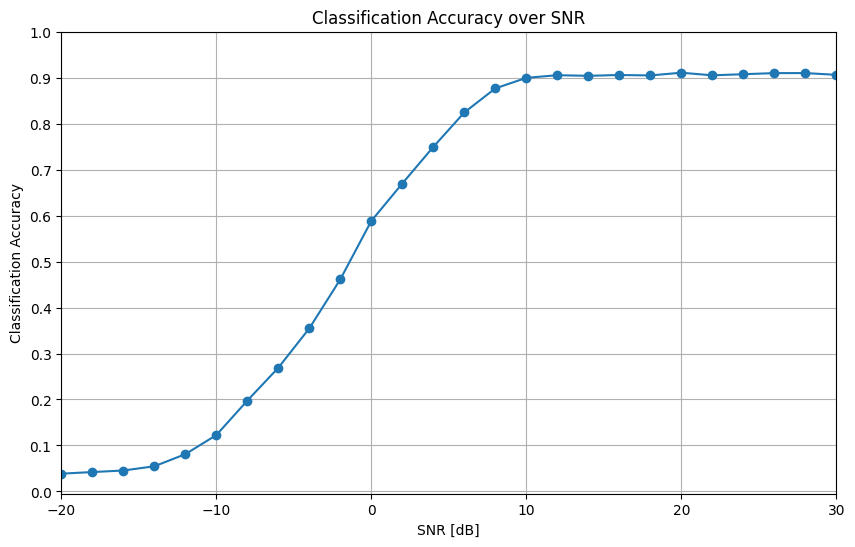

In [22]:
# Plot accuracy over SNR
plt.figure(figsize=(10,6))
plt.plot(dataset.snr_classes, acc, marker='o')
plt.xlabel("SNR [dB]")
plt.xlim([-20, 30])
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Classification Accuracy over SNR")
plt.grid()
plt.title("Classification Accuracy over SNR");

print("Accuracy @ highest SNR (+30 dB): %f"%(acc[-1]))
print("Accuracy overall: %f"%(np.mean(acc)))

## Breakdown of the accuracy of each modulations over SNRs

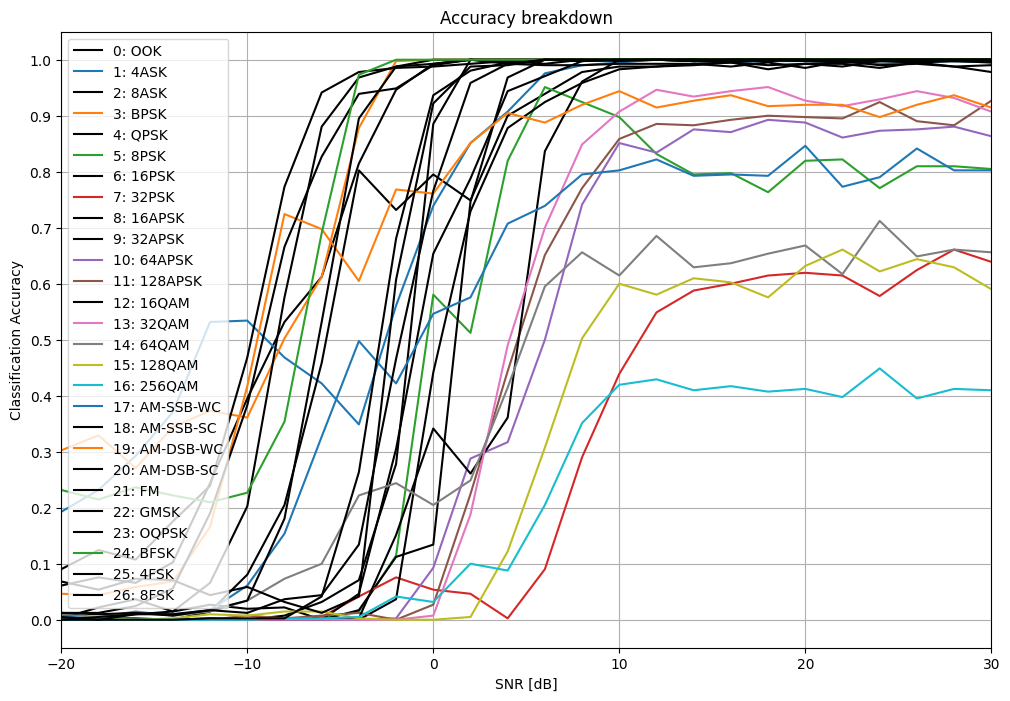

In [23]:
# Plot accuracy per modulation
accs = []
for mod in range((dataset.num_classes)):
    accs.append([])
    for snr in dataset.snr_classes:
        indices = ((y_exp == mod) & (y_snr == snr)).nonzero()
        y_exp_i = y_exp[indices]
        y_pred_i = y_pred[indices]
        cor = np.count_nonzero(y_exp_i == np.argmax(y_pred_i, axis=1))
        accs[mod].append(cor/len(y_exp_i))
        
# Plot accuracy-over-SNR curve
plt.figure(figsize=(12,8))
for mod in range(dataset.num_classes):
    if accs[mod][-1] < 0.95 or accs[mod][0] > 0.1:
        color = None
    else:
        color = "black"
    plt.plot(dataset.snr_classes, accs[mod], label=str(mod) + ": " + dataset.mod_classes[mod], color=color)
plt.xlabel("SNR [dB]")
plt.xlim([-20, 30])
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Accuracy breakdown")
plt.grid()
plt.legend();

## Export model as QONNX (Quantized ONNX) file

QONNX is just a extended version of ONNX file. 

QONNX file is still saved under the extension `.onnx`, but their parameters are quantized

To standardize the project, we will call:
- QONNX Model exported from Brevitas: `_brevitas.onnx`
- QONNX Model after network surgery: `_finn.onnx`

Further information about FINN-ONNX and network surgery is explained in the `build_transformed_model.ipynb`

### Clean up the model so that FINN can regconize nodes

Ensure the model is cleaned up before converting to FINN ONNX, so that the nodes in the model are correctly labeled. Otherwise, when we convert to FINN-ONNX, the converter may not be able to regconize the nodes.

Source code for cleanup(): https://github.com/fastmachinelearning/qonnx/blob/main/src/qonnx/util/cleanup.py

In [25]:
from qonnx.util.cleanup import cleanup as qonnx_cleanup
model_file_name=Path('27ml_rf/model_brevitas.pth')
from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup

model.eval()
build_dir="27ml_rf/models" #Directory to save model

#Ensuring path exist, otherwise create an empty directory
Path(build_dir).mkdir(exist_ok=True)
export_path=f"{build_dir}/radio_27ml_brevitas.onnx" #Full name of the path of the model with the tail _export.onnx
export_qonnx(model.to('cuda'), torch.randn(1, 2, 1024).to('cuda'), export_path=export_path);

qonnx_cleanup(export_path, out_file=export_path)
print(f'model is saved in {export_path}')

model is saved in 27ml_rf/models/radio_27ml_brevitas.onnx
